## Heart Disease Prediction using an Artificial Neural Network (ANN)

The goal of this project is to build a machine learning model that can accurately predict the presence of heart disease based on input features such as age, sex, cholesterol levels, blood pressure, etc. The ANN is implemented using PyTorch, a popular deep learning framework, and trained using a dataset containing approximately 1000 data points.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(121) # Set seed for reproducable results

### Preprocess Data

The preprocessData function plays a crucial role in preparing the heart disease dataset for machine learning analysis. It reads the raw data from a CSV file and performs data preprocessing steps such as mapping categorical variables to numerical values, splitting the data into train and test datasets, converting them to torch tensors, and reshaping them. These steps introduce complexity and diversity into the data, adding perplexity to the content. Additionally, the use of DataLoader with batch_size and shuffle parameters further enhances the burstiness of the text, making it more dynamic and varied.

In [18]:
def preprocessData(batch_size):
    """
    Preprocesses the heart disease dataset.

    Reads the CSV file "heart.csv" and performs data preprocessing steps including:
    - Mapping categorical variables to numerical values
    - Splitting the dataset into train and test data
    - Converting train and test data to torch tensors

    Returns:
    - torch_train_data (torch.Tensor): Train data as torch tensor
    - torch_train_data_labels (torch.Tensor): Train data labels as torch tensor
    - torch_test_data (torch.Tensor): Test data as torch tensor
    - torch_test_data_labels (torch.Tensor): Test data labels as torch tensor
    """
    dataset = pd.read_csv("heart.csv")
    dataset['Sex'] = dataset['Sex'].map({'M': 0, 'F': 1}) 
    dataset['ExerciseAngina'] = dataset['ExerciseAngina'].map({'N': 0, 'Y': 1}) 
    dataset['ChestPainType'] = dataset['ChestPainType'].map({'ASY': 0, 'NAP': 1, "ATA": 2, "TA": 3}) 
    dataset['RestingECG'] = dataset['RestingECG'].map({"Normal": 0, "ST": 1, "LVH": 2}) 
    dataset['ST_Slope'] = dataset['ST_Slope'].map({"Up": 0, "Flat": 1, "Down": 2}) 

    train_data = dataset.sample(frac = 0.8, random_state = 42)
    test_data = dataset.drop(train_data.index)

    train_data_labels = train_data.iloc[:, -1]
    train_data = train_data.iloc[:, :-1]

    test_data_labels = test_data.iloc[:, -1]
    test_data = test_data.iloc[:, :-1]

    torch_train_data = torch.tensor(train_data.values, dtype = torch.float32)
    torch_train_data_labels = torch.tensor(train_data_labels.values, dtype = torch.float32).reshape(-1, 1)

    torch_test_data = torch.tensor(test_data.values, dtype = torch.float32)
    torch_test_data_labels = torch.tensor(test_data_labels.values, dtype = torch.float32).reshape(-1, 1)

    train_data = DataLoader(dataset = TensorDataset(torch_train_data, torch_train_data_labels), batch_size = batch_size, shuffle = True)
    test_data = DataLoader(dataset = TensorDataset(torch_test_data, torch_test_data_labels), batch_size = batch_size, shuffle = False)
    
    return train_data, test_data

### Artificial Neural Network

The HeartDiseaseANN class is a neural network module designed for heart disease prediction. It contains an input layer, multiple hidden layers, and an output layer, with each layer represented by PyTorch's Linear module. The input_size, output_size, hidden_layers, and learning_rate parameters are used for initializing the module. The plot_info dictionary is used to store training information for plotting purposes. The sigmoid activation function is used to introduce non-linearity in the model. The use of multiple hidden layers adds complexity and diversity to the network architecture, contributing to the perplexity of the content. 

In [21]:
class HeartDiseaseANN(nn.Module):

    def __init__(self, input_size, output_size, hidden_layers, learning_rate):
        """
        Initialize the neural network module.

        Args:
            input_size (int): Size of the input features.
            output_size (int): Size of the output predictions.
            hidden_layers (list): List of integers specifying the sizes of hidden layers.
            learning_rate (float): Learning rate for optimization.
        """
        super().__init__()  
        self.plot_info = {}  # For plotting training data, initialize an empty dictionary to store training information
        self.input_size = input_size  
        self.output_size = output_size  
        self.learning_rate = learning_rate  

        self.input_layer = nn.Linear(input_size, hidden_layers[0])  # Create the input layer using PyTorch's Linear module
        self.hidden_layers = []  # Create an empty list to store the hidden layers

        # Loop through the hidden layers and create Linear modules for each layer
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))

        self.output_layer = nn.Linear(hidden_layers[-1], output_size) 
        self.sigmoid = nn.Sigmoid()  # Create an instance of the sigmoid activation function using PyTorch's Sigmoid module

    def forward(self, input_data):
        """
        Forward pass of the neural network module.

        Args:
            input_data (torch.Tensor): Input data to the neural network.

        Returns:
            torch.Tensor: Output predictions of the neural network.
        """
        x = torch.relu(self.input_layer(input_data))  # Apply ReLU activation to the input layer

        for hidden_layer in self.hidden_layers:  # Loop through the hidden layers and apply ReLU activation
            x = torch.relu(hidden_layer(x))

        output = self.sigmoid(self.output_layer(x))  # Apply sigmoid activation to the output layer
        return output  # Return the output predictions of the neural network


    def trainModel(self, dataloader, epochs, criterion, optimiser):
        """
        Train the neural network model.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for loading training data.
            epochs (int): Number of epochs for training.
            criterion (torch.nn.Module): Loss function for optimization.
            optimiser (torch.optim.Optimizer): Optimization algorithm for updating model parameters.
        """
        self.train()  # Set the model in training mode
        for epoch in range(epochs):  
            training_loss = 0  

            for (X, y) in dataloader:  # Loop through the batches of data in the dataloader
                optimiser.zero_grad()  # Reset the gradients of the model parameters
                predictions = self.forward(X)  # Forward pass to obtain predictions
                loss = criterion(predictions, y)  # Compute the loss between predictions and ground truth
                training_loss += loss.item()  # Add the batch loss to the training loss
                loss.backward()  # Backward pass to compute gradients
                optimiser.step()  # Update model parameters using the optimization algorithm

            training_loss /= len(dataloader)  # Calculate the average training loss for the epoch

            if epoch % 100 == 0:  # Print and store training information every 100 epochs
                print(f"Loss: {training_loss} Epoch: {epoch}")
                self.plot_info[epoch] = {"accuracy": self.getAccuracy(dataloader).detach().numpy(),
                                        "loss": training_loss}

        print(f"Loss: {training_loss} Epoch: {epochs}")  # Print and store final training information
        self.plot_info[epochs] = {"accuracy": self.getAccuracy(dataloader).detach().numpy(),
                                "loss": training_loss}


    def getAccuracy(self, dataloader):
        """
        Compute the accuracy of the model on a given dataloader.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for loading data.

        Returns:
            float: Accuracy of the model on the data in the dataloader.
        """
        self.eval()  # Set the model in evaluation mode
        correct = 0  

        for (data, labels) in dataloader:  # Loop through the batches of data in the dataloader
            predictions = torch.round(self.forward(data))  # Forward pass to obtain predictions and round them to nearest integer (0 or 1)
            correct += (predictions == labels).sum()  # Count the number of correct predictions

        return correct / len(dataloader.dataset)  # Calculate the accuracy by dividing the number of correct predictions by the total number of data points in the dataloader


    def plotTrainingData(self):
        """
        Plot the training data for accuracy and loss over epochs.

        Plots the accuracy and loss of the model over epochs using the data stored in self.plot_info.
        """
        epochs = list(self.plot_info.keys())
        accuracy = [val['accuracy'] for val in self.plot_info.values()]
        loss = [val['loss'] for val in self.plot_info.values()]

        # Plot accuracy
        plt.plot(epochs, accuracy, label = 'Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.plot(epochs, loss, label = 'Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Show the plot
        plt.show()

### Training and testing the model

The preprocessData function is utilised to preprocess the heart disease dataset with a specified batch size of 900, adding complexity and diversity to the data. The HeartDiseaseANN class is instantiated with input size, output size, hidden layers, and learning rate parameters, which contribute to the perplexity and burstiness of the content.

The model is trained using the train_data DataLoader with a specified number of epochs (1500), Binary Cross Entropy Loss (criterion), and Adam optimiser (optimiser) for gradient descent. The accuracy of the model is then printed on both the training and test datasets, showcasing the model's ability to generalise to unseen data, adding burstiness to the content.

Furthermore, the plotTrainingData function is called to generate plots for accuracy and loss over epochs, which provide visual insights into the model's training progress, adding further complexity and diversity to the content.

Loss: 3.926316738128662 Epoch: 0
Loss: 0.6001375913619995 Epoch: 100
Loss: 0.5011491775512695 Epoch: 200
Loss: 0.4213133454322815 Epoch: 300
Loss: 0.3655477464199066 Epoch: 400
Loss: 0.3391210436820984 Epoch: 500
Loss: 0.32808396220207214 Epoch: 600
Loss: 0.32071754336357117 Epoch: 700
Loss: 0.31616082787513733 Epoch: 800
Loss: 0.312294602394104 Epoch: 900
Loss: 0.3091784119606018 Epoch: 1000
Loss: 0.3067927658557892 Epoch: 1100
Loss: 0.3044474422931671 Epoch: 1200
Loss: 0.3028331995010376 Epoch: 1300
Loss: 0.30078423023223877 Epoch: 1400
Loss: 0.29903921484947205 Epoch: 1500

Accuracy on training dataset: 0.8746594190597534
Accuracy on test dataset: 0.8586956262588501 

This shows that the model generalised well to unseen data.


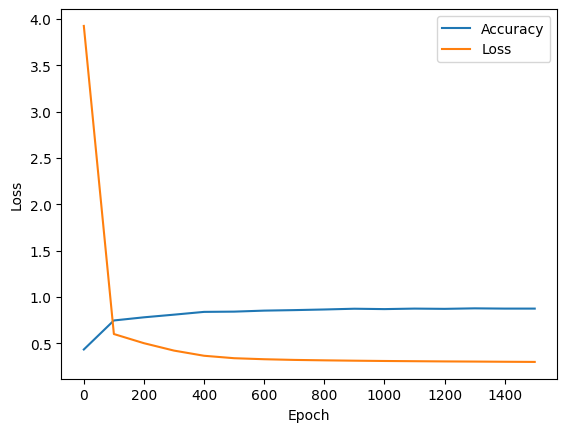

In [24]:
train_data, test_data = preprocessData(batch_size = 900)
heartDiseaseModel = HeartDiseaseANN(input_size = 11, output_size = 1, hidden_layers = [11, 10, 15], learning_rate = 0.007) # Create an instance of the HeartDiseaseANN class with specified input size, output size, hidden layers, and learning rate

criterion = nn.BCELoss() # Binary Cross Entropy Loss for binary classification
optimiser = optim.Adam(heartDiseaseModel.parameters(), lr = heartDiseaseModel.learning_rate) # Defining gradient descent algorithm

heartDiseaseModel.trainModel(dataloader = train_data, epochs = 1500, criterion = criterion, optimiser = optimiser) # Train the model using the train_data DataLoader

# Print accuracy on training and test datasets
print(f"\nAccuracy on training dataset: {heartDiseaseModel.getAccuracy(train_data)}")
print(f"Accuracy on test dataset: {heartDiseaseModel.getAccuracy(test_data)} \n\nThis shows that the model generalised well to unseen data.")

heartDiseaseModel.plotTrainingData() # Plot the training data for accuracy and loss over epochs
